## Implied Volatility Surface Plotter

Progression on the Implied Volatility Calculation through the Black-Scholes-Merton Model via the Newton-Ralphson Loss Function.

Utilized the yFinance package to pull live data into a Pandas Dataframe and plotted data in a 3-Dimensional Graph with Mathplotlib.

Next Steps: Make a Python File and utilize a GUI package to create a user interface to select Stock, Dividend Forecast, and Risk-Free-Rate.

In [28]:
from jax.scipy.stats import norm as jnorm
import jax.numpy as jnp
from jax import grad

import yfinance as yf
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

from datetime import datetime, timezone, timedelta
from typing import Literal, Optional, Tuple

In [29]:
# Black Scholes Formula
def black_scholes(S, K, T, r, sigma, q=0, otype='call'):
    d1 = (jnp.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * jnp.sqrt(T))
    d2 = d1 - sigma * jnp.sqrt(T)
    if otype == 'call':
        call = S * jnp.exp(-q * T) * jnorm.cdf(d1, 0, 1) - K * jnp.exp(-r * T) * jnorm.cdf(d2, 0, 1)
        return call
    else:
        put = K * jnp.exp(-r * T) * jnorm.cdf(-d2, 0, 1) - S * jnp.exp(-q * T) * jnorm.cdf(-d1, 0, 1)
        return put

In [30]:
# Loss Function
def loss(S, K, T, r, sigma_guess, price, q=0, otype="call"):

    #Price with GUESS for Volatility
    theoretical_price = black_scholes(S, K, T, r, sigma_guess, q, otype)

    market_price = price

    return theoretical_price - market_price

loss_grad = grad(loss, argnums=4)

In [31]:
# Solver using Newton-Raphson Method
def solve_for_iv(S, K, T, r, price, sigma_guess = 1.8, q=0, otype="call", N_iter = 20, epsilon = 0.001, verbose = True):
    
    converged = False
    
    #1. Guess for Volatility
    sigma = sigma_guess
    for i in range(N_iter):
        #print("\nIteration:", i)
        #2. calculate loss function
        loss_val = loss(S, K, T, r, sigma, price, q, otype)

        if verbose:
            print("Current Error in Theoretical vs Market Price:")
            print(loss_val)
        
        #3. Check if loss is less than the tolerance

        #If yes, STOP!
        if abs(loss_val) < epsilon:
            converged = True
            break

        #If no, CONTINUE to Step 4.
        else:

            #4. Calculate gradient of loss function.
            loss_grad_val = loss_grad(S, K, T, r, sigma, price, q, otype)

            if verbose:
                print("Gradient: ", loss_grad_val)

            #5. Update the volatility using the Newton-Raphson formula
            sigma = sigma - loss_val / loss_grad_val

            if verbose:
                print("New Sigma: ", sigma)
    
    if not converged:
        print("Warning: Did not converge")
    return sigma

In [32]:
# Get Options Chain from Yahoo Finance
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    currentPrice = tk.history(period='1d')['Close'][0]
    exps = tk.options

    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame()._append(opt.calls)
        opt.insert(0, 'symbol', symbol)
        opt.insert(1, 'S', currentPrice)
        opt['expirationDate'] = e
        options = options._append(opt, ignore_index=True)

    options['expirationDate'] = pd.to_datetime(options['expirationDate']) + timedelta(days=1)
    options['dte'] = (options['expirationDate'] - datetime.today()).dt.days / 365

    #options['CALL'] = options['contractSymbol'].str[4:].apply(lambda x: "C" in x)

    options[['strike']] = options[['strike']].apply(pd.to_numeric)
    #options['mark'] = (options['bid'] + options['ask']) / 2

    options = options.drop(columns=['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'bid', 'ask',
                                     'impliedVolatility', 'inTheMoney', 'volume', 'openInterest', 'contractSymbol'])
    
    options = options.rename(columns={'lastPrice': 'C', 'strike': 'K', 'dte': 'T'})

    return options

#options_chain("AAPL")

In [33]:
ivs = []
moneyness = []
dtes = []
r = 0.045
for index, row in options_chain("AAPL").iterrows():
    iv = solve_for_iv(S=row['S'], K=row['K'], T=row['T'], r=r, price=row['C'], sigma_guess=0.3, q=0, otype="call", N_iter=20, epsilon=0.001, verbose=False)
    ivs.append(iv)
    moneyness.append(row['K'] / row['S'])
    dtes.append(row['T'])

/var/folders/s7/1fvm_g7n08nc1mjy67trpddh0000gn/T/ipykernel_2517/2626907363.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  currentPrice = tk.history(period='1d')['Close'][0]


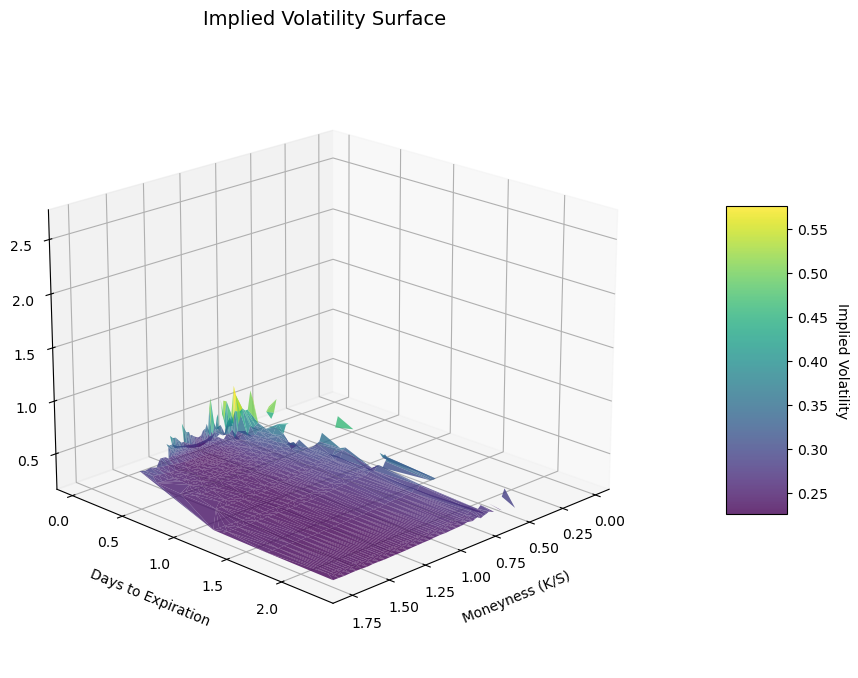

In [34]:
fig = plt.figure(figsize=(12, 8), dpi = 100)
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(moneyness, dtes, ivs, 
                       cmap='viridis',
                       linewidth = 0.1,
                       antialiased=True,
                       alpha=0.8)

cbar = fig.colorbar(surf, ax = ax, shrink=0.5, aspect=5, pad=0.1)
cbar.set_label('Implied Volatility', rotation=270, labelpad=15)

ax.set_xlabel('Moneyness (K/S)', labelpad=10)
ax.set_ylabel('Days to Expiration', labelpad=10)
ax.set_zlabel('Implied Volatility', labelpad=10)

plt.title('Implied Volatility Surface', pad=20, size=14)

ax.view_init(elev = 20, azim = 45)

plt.show()